In [143]:
# import pandas as pd
# df = pd.read_csv('datasets/artificial/sea/SEA_training_data.csv', delimiter=' ', header=None)
# df.iloc[:,0:2].to_csv('datasets/artificial/sea/SEA_training_data_xy.csv', sep=' ' ,index=False, header=False)

In [1]:
import copy
import csv
from river import ensemble, forest, linear_model, metrics, neighbors, preprocessing, tree
from datetime import datetime

bases = {
    # 'sea': {
    #     'data': 'datasets/artificial/sea/SEA_training_data_xy.csv',
    #     'labels': 'datasets/artificial/sea/SEA_training_class.csv',
    #     'fieldnames': {'x', 'y'},
    # },
    # 'chess': {
    #     'data': 'datasets/artificial/chess/transientChessboard.data',
    #     'labels': 'datasets/artificial/chess/transientChessboard.labels',
    #     'fieldnames': {'x', 'y'},
    # },
    # 'rbf': {
    #     'data': 'datasets/artificial/rbf/movingRBF.data',
    #     'labels': 'datasets/artificial/rbf/movingRBF.labels',
    #     'fieldnames': {'x0', 'x1', 'x2', 'x3', 'x4',
    #                    'x5', 'x6', 'x7', 'x8', 'x9'},
    # },
    'squares': {
        'data': 'datasets/artificial/movingSquares/movingSquares.data',
        'labels': 'datasets/artificial/movingSquares/movingSquares.labels',
        'fieldnames': {'x', 'y'},
    },
    # 'weather': {
    #     'data': 'datasets/realWord/weather/NEweather_data.csv',
    #     'labels': 'datasets/realWord/weather/NEweather_class.csv',
    #     'fieldnames': {'x0', 'x1', 'x2', 'x3',
    #                    'x4', 'x5', 'x6', 'x7'},
    # },
    # 'poker': {
    #     'data': 'datasets/realWord/poker/poker.data',
    #     'labels': 'datasets/realWord/poker/poker.labels',
    #     'fieldnames': {'x0', 'x1', 'x2', 'x3', 'x4',
    #                    'x5', 'x6', 'x7', 'x8', 'x9'},
    # },
}

all_metrics = [
    'Accuracy',
    'Precision',
    'Recall',
    'F1',
    'GeometricMean',
]

for bas in bases:

    algos = {
        'neighbors': neighbors.SAMKNNClassifier(),
        'ensemble': ensemble.LeveragingBaggingClassifier(tree.HoeffdingTreeClassifier()),
        # 'tree': tree.ExtremelyFastDecisionTreeClassifier(),
        'forest': forest.ARFClassifier(),
    }

    print(f'starting {bas}, at {datetime.now()}')

    try:
        f = open(bases[bas]['labels'], 'r')
        y = []
        for line in f.readlines():
            y.append(int(line))
        f.close()
        print(f'import {bas} labels, ok!')
    except:
        print('Y not found')
    try:
        f = open(bases[bas]['data'], 'r')
        x = csv.DictReader(
            f,
            delimiter=' ',
            quoting=csv.QUOTE_NONNUMERIC,
            fieldnames=bases[bas]['fieldnames']
        )
        print(f'import {bas} data, ok!')
    except:
        print('X not found')

    models = {}
    result = {}
    for mod in algos:
        models[mod] = copy.deepcopy(algos[mod])
        _metric = {'y_pred': None}
        for m in all_metrics:
            _m = getattr(metrics, m)()
            _metric.update({m: _m})
        result.update({mod: _metric})

    try:
        w = open(f'results/{bas}.csv', 'w')
        writer = csv.writer(w)
        writer.writerow(['instance',
                         'model',
                         'Accuracy',
                         'Precision',
                         'Recall',
                         'F1'
                         ])
    except:
        print('Result file can\'t be opened')

    for i, _x in enumerate(x):
        for mod in algos:
            

            # Test Then Train
            # Test
            result[mod]['y_pred'] = models[mod].predict_one(_x)
            # Train
            models[mod].learn_one(_x, y[i])

            if result[mod]['y_pred'] is not None:
                a = [i, mod]
                for m in all_metrics:
                    result[mod][m].update(y[i], result[mod]['y_pred'])
                    a.append(result[mod][m].get())

                writer.writerow(a)
    print(f'finishing {bas}, at {datetime.now()}')
    w.close()
    f.close()

starting squares, at 2023-07-11 21:30:20.859847
import squares labels, ok!
import squares data, ok!
finishing squares, at 2023-07-11 22:10:41.799568


In [9]:
_x

{'x': 0.0756104, 'y': 0.0055633}

In [15]:
import pandas as pd
from matplotlib import pyplot as plt

_algos = ['ensemble', 'tree', 'forest', 'neighbors']
_bases = ['chess', 'rbf', 'sea', 'squares', 'poker', 'weather']
_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for b in _bases:
    fig, axs = plt.subplots(4, 1)
    # fig.suptitle(f'{b.upper()}', fontsize=18, y=0.95)
    fig.tight_layout(h_pad=None, w_pad=None, rect=None)
    fig.set_figheight(7)
    fig.set_figwidth(12)
    fig.subplots_adjust(hspace=0)
    fig.legend(labels=_algos)
    df = pd.read_csv(f'results/{b}.csv')
    for i, ax in enumerate(fig.axes):
        for a in _algos:
            ax.plot('instance', _metrics[i], data=df[df.model == a])
            ax.set
            ax.set_ylim(0, 1)
            ax.set_xlim(0, df['instance'].max())
            ax.set_yticklabels(['', 0.2, 0.4, 0.6, 0.8])
            ax.set_ylabel(f'{_metrics[i].upper()}')
            if i < 3:
                ax.set_xticklabels('')
            else:
                ax.legend(_algos, loc='lower right')
    fig.savefig(f'results/images/{b}.pdf')
    fig.clf()

/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])
/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])
/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])
/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])
/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])
/tmp/ipykernel_10631/192577545.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',0.2,0.4,0.6,0.8])


<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

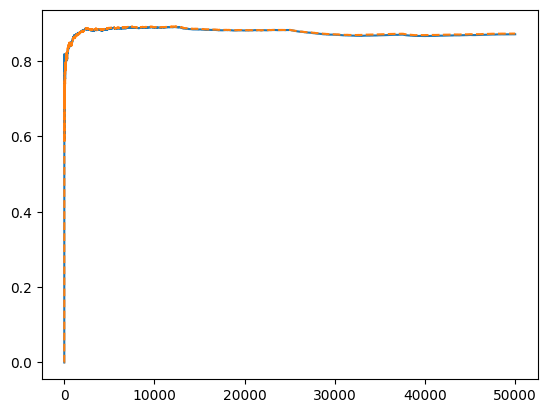

In [18]:
import pandas as pd
from matplotlib import pyplot as plt

df1 = pd.read_csv('results/sea0.csv')
df2 = pd.read_csv('results/sea.csv')

plt.plot('instance', 'Accuracy', data=df1[df1.model == 'forest'])
plt.plot('instance', 'Accuracy',
         data=df2[df2.model == 'forest'], linestyle='dashed')